In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('gapminder_full.csv', sep=',')

# Descrições Iniciais

In [4]:
df.head()

,country,year,pop,continent,lifeExp,gdpPercap
0,Afghanistan,1952,8425333.0,Asia,28.801,779.445314
1,Afghanistan,1957,9240934.0,Asia,30.332,820.853030
2,Afghanistan,1962,10267083.0,Asia,31.997,853.100710
3,Afghanistan,1967,11537966.0,Asia,34.020,836.197138
4,Afghanistan,1972,13079460.0,Asia,36.088,739.981106


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1736 entries, 0 to 1735
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   country    1736 non-null   object 
 1   year       1736 non-null   int64  
 2   pop        1736 non-null   float64
 3   continent  1736 non-null   object 
 4   lifeExp    1736 non-null   float64
 5   gdpPercap  1736 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 81.5+ KB


In [6]:
df.describe()

,year,pop,lifeExp,gdpPercap
count,1736.000000,1.736000e+03,1736.000000,1736.000000
mean,1979.669931,3.156800e+07,59.511979,7240.155986
std,17.296364,1.172888e+08,12.956028,9839.873695
min,1952.000000,6.001100e+04,23.599000,241.165876
25%,1967.000000,2.818694e+06,48.245000,1202.060309
50%,1982.000000,7.150606e+06,60.808000,3534.772106
75%,1997.000000,1.977102e+07,70.945000,9380.254270
max,2007.000000,1.318683e+09,82.603000,113523.132900


# Opções - Mundial
- Análise de Tendência de expectativa de vida mundial
- Países com maior crescimento de expectativa de vida no periodo
- Países com maior decrescimo de expectativa de vida no periodo

# Brasil
- Análise de tendência de expectativa de vida (Precisa complementar os dados)
- Análise de tentência de crescimento de PIB (Precisa complementar os dados)
- Correlação entre crescimento do emprego com a expectativa de vida


- remover duplicados e nulos
- derivar variaveis

In [7]:
df.groupby("country").size()

country
Afghanistan           13
Albania               12
Algeria               12
Angola                12
Argentina             12
                      ..
Vietnam               12
West Bank and Gaza    12
Yemen Rep.            12
Zambia                12
Zimbabwe              12
Length: 142, dtype: int64

In [11]:
df = df.sort_values(["country", "year"])
df["diff_ano"] = df.groupby("country")["year"].diff().fillna(0).astype(int)
df = df.drop_duplicates(subset=['country', 'year'])
df

,country,year,pop,continent,lifeExp,gdpPercap,diff_ano
0,Afghanistan,1952,8425333.0,Asia,28.801,779.445314,0
1,Afghanistan,1957,9240934.0,Asia,30.332,820.853030,5
2,Afghanistan,1962,10267083.0,Asia,31.997,853.100710,5
3,Afghanistan,1967,11537966.0,Asia,34.020,836.197138,5
4,Afghanistan,1972,13079460.0,Asia,36.088,739.981106,5
...,...,...,...,...,...,...,...
1731,Zimbabwe,1987,9216418.0,Africa,62.351,706.157306,5
1732,Zimbabwe,1992,10704340.0,Africa,60.377,693.420786,5
1733,Zimbabwe,1997,11404948.0,Africa,46.809,792.449960,5
1734,Zimbabwe,2002,11926563.0,Africa,39.989,672.038623,5


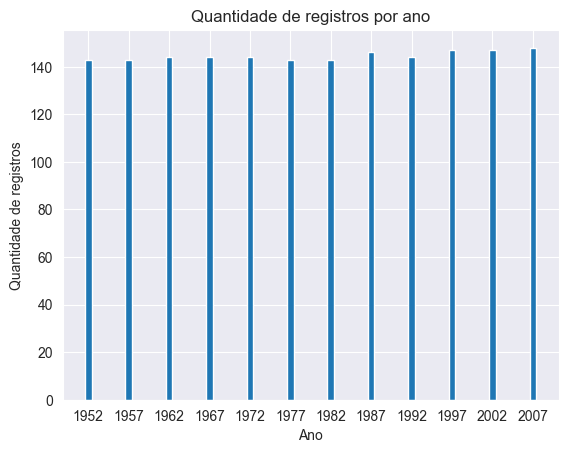

In [9]:
count_por_ano = df.groupby("year").size().reset_index(name="total")
plt.figure()
plt.bar(count_por_ano["year"], count_por_ano["total"])
plt.xlabel("Ano")
plt.ylabel("Quantidade de registros")
plt.title("Quantidade de registros por ano")
plt.xticks(count_por_ano["year"])
plt.show()

In [7]:
df.isnull().sum()

country      0
year         0
pop          0
continent    0
lifeExp      0
gdpPercap    0
dtype: int64

In [10]:
df = df.dropna()
df = df.drop_duplicates()
df

,country,year,pop,continent,lifeExp,gdpPercap
0,Afghanistan,1952,8425333.0,Asia,28.801,779.445314
1,Afghanistan,1957,9240934.0,Asia,30.332,820.853030
2,Afghanistan,1962,10267083.0,Asia,31.997,853.100710
3,Afghanistan,1967,11537966.0,Asia,34.020,836.197138
4,Afghanistan,1972,13079460.0,Asia,36.088,739.981106
...,...,...,...,...,...,...
1731,Zimbabwe,1987,9216418.0,Africa,62.351,706.157306
1732,Zimbabwe,1992,10704340.0,Africa,60.377,693.420786
1733,Zimbabwe,1997,11404948.0,Africa,46.809,792.449960
1734,Zimbabwe,2002,11926563.0,Africa,39.989,672.038623
